## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 100)


-------------
## Training Data at a glace

In [2]:
# Reading in the data
df_train = pd.read_csv("../datasets/train.csv")

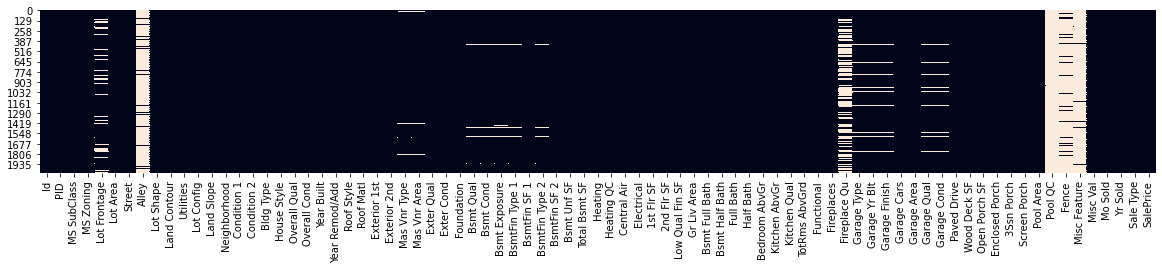

In [3]:
#Heatmap of the the missing values
plt.figure(figsize = (20, 3))
sns.heatmap(df_train.isnull(), cbar=False);

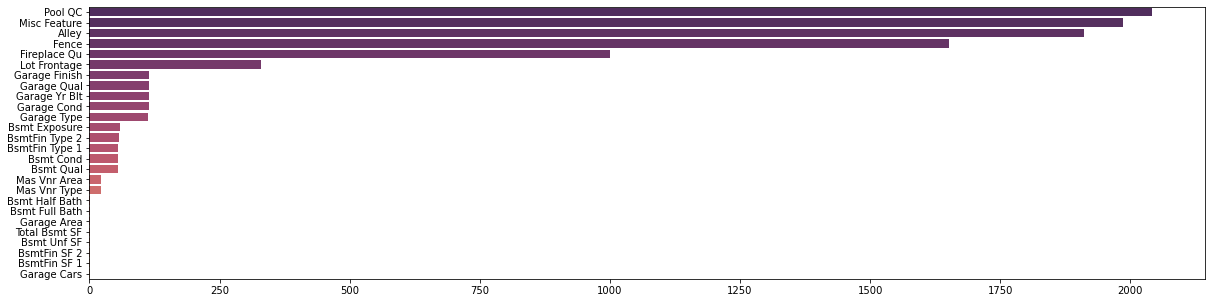

In [4]:
#Barplot of the number of missing values 
missing = df_train.isna().sum().sort_values(ascending = False)
plt.figure(figsize=(20,5))
sns.barplot(missing[missing != 0].values, missing[missing != 0].index,  palette = "flare_r");

* **We can see that there are 26 features that contain null values**
-------
## A Deep Dive into the Data  
### Dealing with the null values

#### The null values in a few of these features mean that the house doesn't have this feature, not that the dataset doesn't have the value
#### In that case I will turn the null values to "None" for the categorical features


In [5]:
nan_to_none_col = [ "Pool QC", "Misc Feature" , "Alley", "Fence", "Fireplace Qu", 
                   "Garage Cond", "Garage Qual", "Garage Finish", "Garage Type", 
                   "Bsmt Exposure", "BsmtFin Type 2", "Bsmt Cond", "Bsmt Qual", 
                   "BsmtFin Type 1", "Mas Vnr Type"]
for col in nan_to_none_col:
    df_train[col].fillna("None", inplace=True)

#### And I will turn the null values to 0 for the numeric features

In [6]:
nan_to_zero_col = ["Mas Vnr Area", "Bsmt Half Bath", "Bsmt Full Bath", "Total Bsmt SF","Bsmt Unf SF",
                   "BsmtFin SF 2","Garage Cars", "Garage Area", "BsmtFin SF 1", "Garage Yr Blt" ]
for col in nan_to_zero_col:
    df_train[col].fillna(0, inplace=True)

#### Lot Frontage largely varies from house to house, so setting the null values as the median might negatively affect the model.
So I'll set the `Lot Frontage` feature equal to the median of its neighborhoods lot frontage, since houses close to each other have similar characteristics.

In [7]:
df_train["Lot Frontage"] = df_train.groupby("Neighborhood")["Lot Frontage"].transform(lambda x: x.fillna(x.median()))

#### Garage from the future...?
Looking at the `Garage Yr Blt` feature, we find a strange maximum; a garage that was built in 2207

In [8]:
df_train["Garage Yr Blt"].describe()

count    2051.000000
mean     1868.725987
std       454.133654
min         0.000000
25%      1957.000000
50%      1978.000000
75%      2001.000000
max      2207.000000
Name: Garage Yr Blt, dtype: float64

We will drop any row with a garage built after 2022, which shouln't be a problem since it is only one row

In [9]:
df_train = df_train[df_train["Garage Yr Blt"] < 2022]

### Checking of there are any null values left

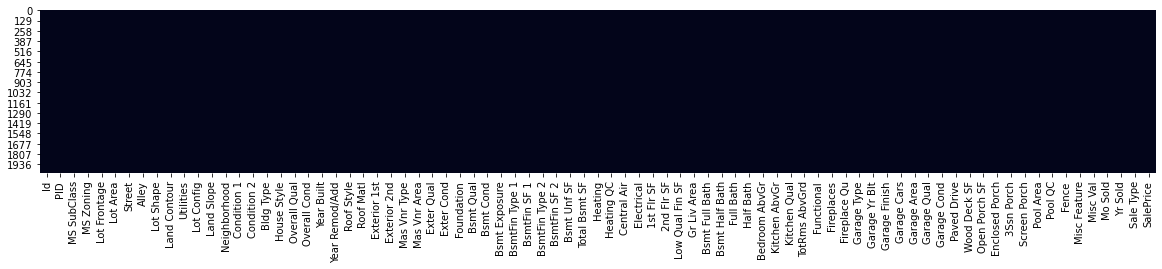

In [25]:
plt.figure(figsize = (20, 3))
sns.heatmap(df_train.isnull(), cbar=False);

### Changing Ordinal Values to Discrete Values
#### Since the values of ordinal features are ordered, I'll be able to turn them into numeric values

In [11]:
y_n = {'Y':2,
       'P':1,
       'N':0}

gtl_sev = {'Gtl':2,
           'Mod':1,
           'Sev':0}

reg_ir = {'Reg':3,
          'IR1':2,
          'IR2':1, 
          'IR3':0}

ap_elo = {'AllPub':3,
          'NoSewr':2,
          'NoSeWa':1,
          'ELO':0}

fin_none = {'Fin':3,
            'RFn':2,
            'Unf':1, 
            'None':0 }

gd_none = {'Gd':4, 
           'Av':3,
           'Mn':2,
           'No':1, 
           'None':0}

gdprv_none = {'GdPrv':4,
           'MnPrv':3,
           'GdWo':2,
           'MnWw':1,
           'None':0}

sbrkr_mix = {'SBrkr':4,
             'FuseA':3,
             'FuseF':2, 
             'FuseP':1,
             'Mix':0}

ex_none = {'Ex':5,
           'Gd':4, 
           'TA':3, 
           'Fa':2, 
           'Po':1, 
           'None':0}

glq_none = {'GLQ':6,
            'ALQ':5,
            'BLQ':4,
            'Rec':3,
            'LwQ':2,
            'Unf':1, 
            'None':0}

typ_sal = {'Typ':7,
           'Min1':6,
           'Min2':5, 
           'Mod':4, 
           'Maj1':3, 
           'Maj2':2,
           'Sev':1,
           'Sal':0}

In [12]:
def OrdinalEncoder(df):
    ex_none_col = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', 'Kitchen Qual','Fireplace Qu','Garage Qual','Garage Cond', 'Pool QC',"Heating QC"]
    for col in ex_none_col: 
        df[col] =  df[col].map(ex_none)
    glq_none_col = ['BsmtFin Type 1','BsmtFin Type 2']
    for col in glq_none_col:
        df[col] =  df[col].map(glq_none)
    df['Paved Drive'] =  df['Paved Drive'].map(y_n)
    df['Land Slope'] =  df['Land Slope'].map(gtl_sev)
    df['Lot Shape'] =  df['Lot Shape'].map(reg_ir)
    df['Utilities'] =  df['Utilities'].map(ap_elo)
    df['Fence'] =  df['Fence'].map(gdprv_none)
    df['Garage Finish'] =  df['Garage Finish'].map(fin_none)
    df['Bsmt Exposure'] =  df['Bsmt Exposure'].map(gd_none)
    df['Electrical'] =  df['Electrical'].map(sbrkr_mix)
    df['Functional'] =  df['Functional'].map(typ_sal)
    return df

In [13]:
encoded_train = OrdinalEncoder(df_train)

### Saving the dataframe as a csv for future use

```
encoded_train.to_csv("../datasets/train_clean.csv", index=False)
```

---------------

## Cleaning up the Testing Data

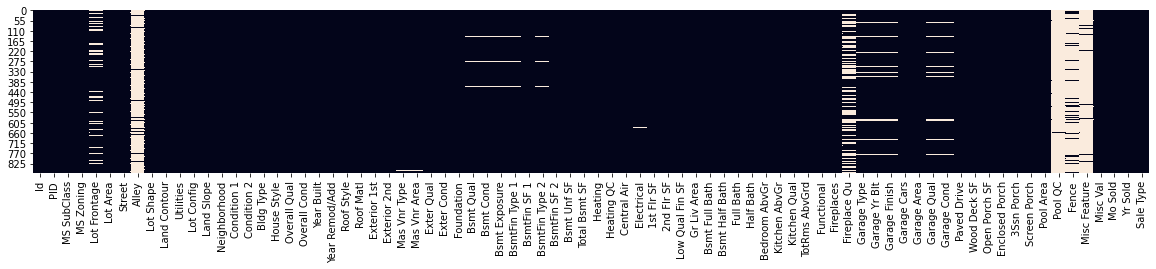

In [15]:
df_test = pd.read_csv("../datasets/test.csv")
plt.figure(figsize = (20, 3))
sns.heatmap(df_test.isnull(), cbar=False);

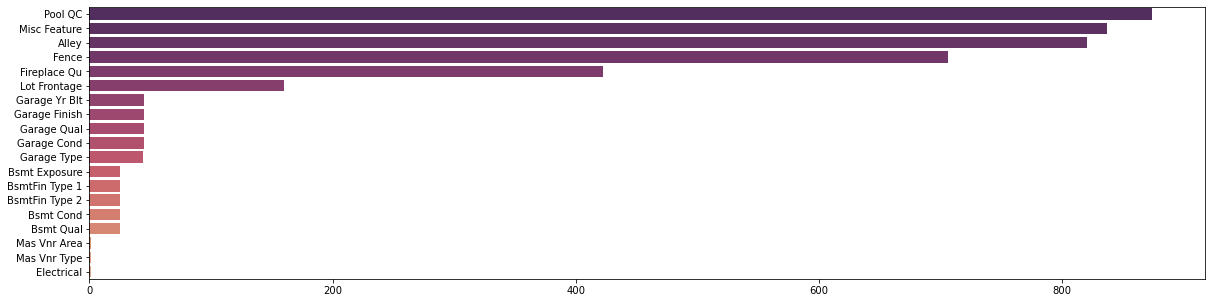

In [16]:
missing = df_test.isna().sum()
missing = missing.drop(missing[missing == 0].index).sort_values(ascending = False)

plt.figure(figsize=(20,5))
sns.barplot(missing.values, missing.index,  palette = "flare_r");

#### The features that are missing in the testing data is similar to the ones that were missing on the training data.
#### So I will fill in the values similarly to how I filled them in the traing dataset

In [17]:
nan_to_none_col = [ "Pool QC", "Misc Feature" , "Alley", "Fence", "Fireplace Qu", 
                   "Garage Cond", "Garage Qual", "Garage Finish", "Garage Type", 
                   "Bsmt Exposure", "BsmtFin Type 2", "Bsmt Cond", "Bsmt Qual", 
                   "BsmtFin Type 1", "Mas Vnr Type"]
for col in nan_to_none_col:
    df_test[col].fillna("None", inplace=True)

In [18]:
nan_to_zero_col = ["Mas Vnr Area", "Bsmt Half Bath", "Bsmt Full Bath", "Total Bsmt SF","Bsmt Unf SF",
                   "BsmtFin SF 2","Garage Cars", "Garage Area", "BsmtFin SF 1", "Garage Yr Blt" ]
for col in nan_to_zero_col:
    df_test[col].fillna(0, inplace=True)

In [19]:
df_test["Lot Frontage"] = df_test.groupby("Neighborhood")["Lot Frontage"].transform(lambda x: x.fillna(x.median()))

#### The Electrical feature is the only feature that wasn't missing in the training df, that is missing in the testing df. So I'll take a closer look into it to see how I should fill in the value

In [20]:
df_train["Electrical"].value_counts()

4    1867
3     140
2      35
1       7
0       1
Name: Electrical, dtype: int64

Seeing that SBrkr is overwhelmingly the most frequently used, I'll use that to fill the vissing value

In [21]:
df_test.replace(np.nan, "SBrkr", inplace=True)

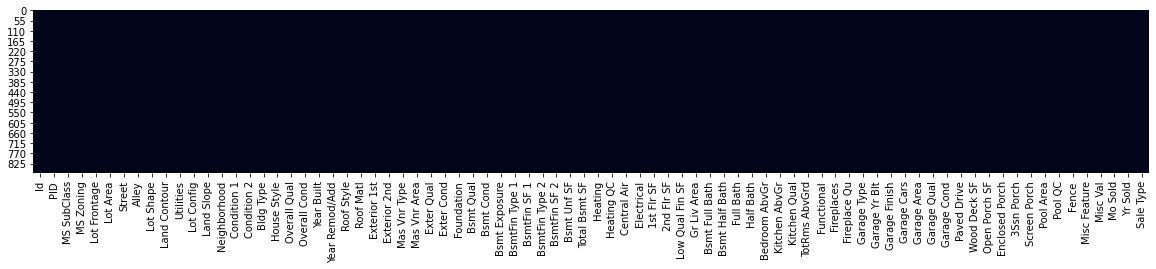

In [22]:
plt.figure(figsize = (20, 3))
sns.heatmap(df_test.isnull(), cbar=False);

In [23]:
encoded_test = OrdinalEncoder(df_test)

### Saving the dataframe as a csv for future use

```
encoded_test.to_csv("../datasets/test_clean.csv", index=False)
```

---------